In [6]:
import scipy.io
import scipy.stats as stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline  
 
data = scipy.io.loadmat('data/old_faithful.mat')

In [7]:
def rebuild_matrix( meanX, meanY):
    centeredVals = zip(meanX,meanY)
    ValsMatrix = np.zeros((len(centeredVals),2))
    for x in range(len(centeredVals)):
        ValsMatrix[x][0]= centeredVals[x][0]
        ValsMatrix[x][1]= centeredVals[x][1]
    return ValsMatrix

def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

def compute_responsibilities( data_point, gaus_mean, gaus_cov, mix_weight):
    return mix_weight * scipy.stats.multivariate_normal.pdf(data_point, mean= gaus_mean, cov= gaus_cov)

def normalize_responsibilities( totalResp, responsibilities):
    normalized_responsibilities = []
    for resp in responsibilities:
        normalized_responsibilities.append(resp / totalResp)
    normalized_responsibilities = rebuild_matrix( normalized_responsibilities[0], normalized_responsibilities[1])
    return normalized_responsibilities

#This assumes you're sending an array of size i
def update_mus( Nk, normalized_responsibilities, meanMatrix):
    s = normalized_responsibilities * meanMatrix
    sx = np.sum(s[:,0]) / Nk #x-axis 
    sy = np.sum(s[:,1]) / Nk #y-axis
    return [ sx, sy ]
def update_covariance( Nk, normalized_responsibilities, meanMatrix, mu):
    sum = 0
    for i in xrange(len(normalized_responsibilities)):
        sum +=  normalized_responsibilities[i] * np.atleast_2d(meanMatrix[i] - mu).T.dot(np.atleast_2d(meanMatrix[i] - mu))
    new_covariance = sum /  Nk
    #print new_covariance
    return new_covariance

def plot_all(plt, covs, normalized_responsibilities, mus, iteration):
    cov_points = cov_to_pts(covs[0])
    c1, = plt.plot(cov_points[0] + mus[0][0], cov_points[1] + mus[0][1], color="blue", label="Class 1")
    cov_points = cov_to_pts(covs[1])
    c2, = plt.plot(cov_points[0] + mus[1][0], cov_points[1]  + mus[1][1], color="green", label="Class 2")
    plt.title("Iter %d" % iteration)
    plt.scatter(meanX, meanY, color=map(str, normalized_responsibilities[:,0]),cmap='gray', edgecolor='black', linewidth='1')
    
    plt.scatter(mus[0][0], mus[0][1], s=150, color="blue")
    plt.scatter(mus[1][0], mus[1][1], s=150, color="green")
    
    plt.legend(handles=[c1, c2], loc=4)

    plt.xlim(-3,3)
    plt.show()

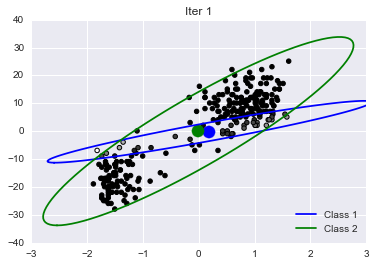

[[ 0.47743388  0.9286136 ]
 [-0.01889158 -0.03674431]]


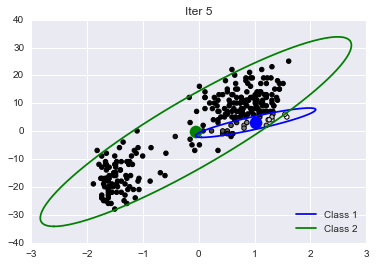

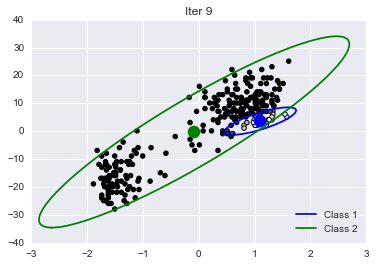

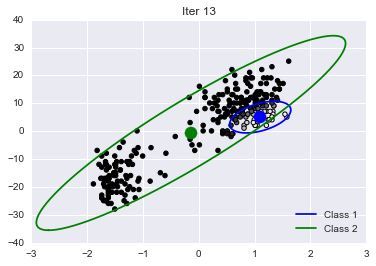

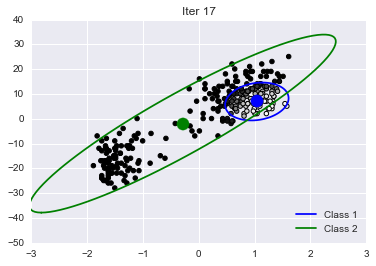

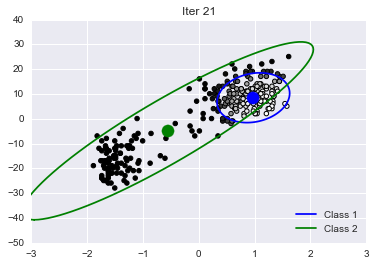

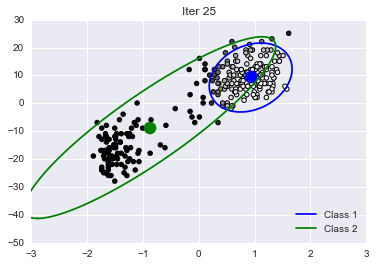

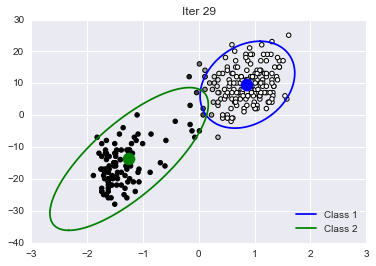

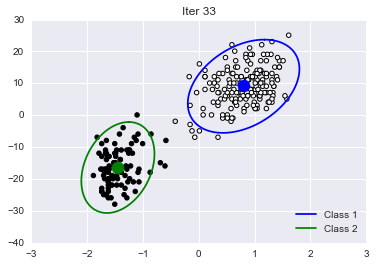

In [8]:
xvals = data['data'][:,0]
yvals = data['data'][:,1]

# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])
 
# the Gaussian covariance matrices
covs = list()
covs.append( 
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append( 
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )
 
# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called alpha in the slides

#plt.scatter(xvals, yvals)

#mean center the data
meanX = xvals - np.mean(xvals)
meanY = yvals - np.mean(yvals)

meanMatrix = rebuild_matrix(meanX, meanY)


#plt.scatter(meanX, meanY)
#plt.scatter(mus[:,0], mus[:,1], color="red")
#plt.show()

for t in xrange(34):
    totalResp = 0
    responsibilities = []
    for x in xrange(len(mws)):
        resp = compute_responsibilities( meanMatrix , mus[x], covs[x], mws[x])
        responsibilities.append(resp)
        totalResp += resp



    normalized_responsibilities = normalize_responsibilities( totalResp, responsibilities)


    Nks = np.apply_along_axis(np.sum, 0, normalized_responsibilities)

    for x in xrange(len(mws)):
        #Update the mixing weights
        mws[x] = Nks[x] / len( normalized_responsibilities )
        #Make sure to send in the correct normalized_responsibilities
        mus[x] = update_mus(Nks[x], np.atleast_2d(normalized_responsibilities[:,x]).T, meanMatrix)
        covs[x] = update_covariance(Nks[x], np.atleast_2d(normalized_responsibilities[:,x]).T, meanMatrix, mus[x])

    if t in [1,5,9,13,17,21,25,29,33]:
        plot_all(plt, covs, normalized_responsibilities, mus, t)
        
    if t == 2:
        print mus